In [46]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "/Users/abdullahfurkanarslan/Desktop/metropt+3+dataset 2/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)

# optional 1

df["data_point_number"] = df.index + 1

# optional 2

df  = mpt.counter_for_maintenance(df , "2020-02-01 00:00:00", f1_finish)
df  = mpt.counter_for_maintenance(df , f1_finish, f2_finish)
df  = mpt.counter_for_maintenance(df , f2_finish, f3_finish)
df  = mpt.counter_for_maintenance(df , f3_finish, f4_finish)
df = mpt.counter_for_maintenance(df, f4_finish, "2020-09-01 03:59:51")

#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =["counter",'data_point_number','TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)

# optional 3

df_clustered = mpt.apply_kmeans_clustering(df_scaled, 5, "condition")

In [47]:
def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    
    probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    probabilities = mpt.get_the_probabilities_with_logistic_regressionn_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)[0]
    y_test = mpt.get_the_probabilities_with_logistic_regressionn_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "no", use1, use2, use3, use4)[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    probabilities = mpt.get_the_probabilities_with_random_forest_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)[0]
    y_test = mpt.get_the_probabilities_with_random_forest_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "no", use1, use2, use3, use4)[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [15]:
df_back_up = df_clustered.copy()

In [43]:
df = df_back_up.copy()

df1 = df.copy() # best but suspicious

df2 = df.drop(labels = ["Cluster", "counter", "data_point_number"], axis = 1)  # OK but not suspicious

df3 = df.drop(labels = ["counter"], axis = 1) # the worst, do not even look at it

df4 = df.drop(labels = ["Cluster"], axis = 1)

df5 = df.drop(labels = ["Caudal_impulses", "Oil_level"], axis = 1)

df6 = df.drop(labels = ["TP2", "TP3", "Caudal_impulses", "Oil_level"], axis = 1)

df7 = df.drop(labels = ["TP2", "TP3", "Caudal_impulses", "Oil_level", "data_point_number"], axis = 1)

                   Coefficient  p_value
data_point_number    12.107742      0.0
LPS                  -6.122426      0.0
Cluster               5.537742      0.0
Oil_temperature       4.718006      0.0
counter               4.444362      0.0
DV_eletric           -3.043123      0.0
Reservoirs           -2.813568      0.0
COMP                 -1.440585      0.0
MPG                  -1.263801      0.0
H1                    1.042919      0.0
Motor_current        -0.925942      0.0
DV_pressure          -0.442419      0.0
Pressure_switch       0.105011      0.0
Towers                0.027981      0.0
Intercept: -22.04959436120924
R-squareddd: 0.9709144885773842
F-Value: 375972.0905340262


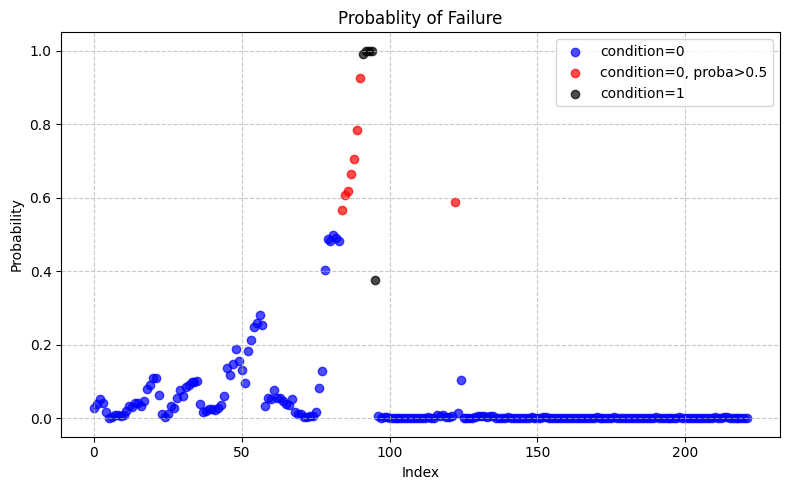

In [44]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df6

aggregated_probabilities = aggregate(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

17
(18, 18)
                        TP2       TP3        H1  DV_pressure  Reservoirs  \
TP2                1.000000  0.019995 -0.972392     0.743961    0.019355   
TP3                0.019995  1.000000  0.167035    -0.069652    0.999995   
H1                -0.972392  0.167035  1.000000    -0.744071    0.167630   
DV_pressure        0.743961 -0.069652 -0.744071     1.000000   -0.069470   
Reservoirs         0.019355  0.999995  0.167630    -0.069470    1.000000   
Oil_temperature    0.455046  0.299536 -0.396106     0.572927    0.300051   
Motor_current      0.745567  0.476267 -0.651596     0.559147    0.475696   
COMP              -0.857342  0.075118  0.868883    -0.656877    0.075676   
DV_eletric         0.857210  0.121633 -0.833339     0.656150    0.121131   
Towers            -0.489562  0.080520  0.506270    -0.372492    0.080862   
MPG               -0.760193 -0.064321  0.746902    -0.581653   -0.063856   
LPS                0.044540 -0.274891 -0.087437    -0.015535   -0.275576   


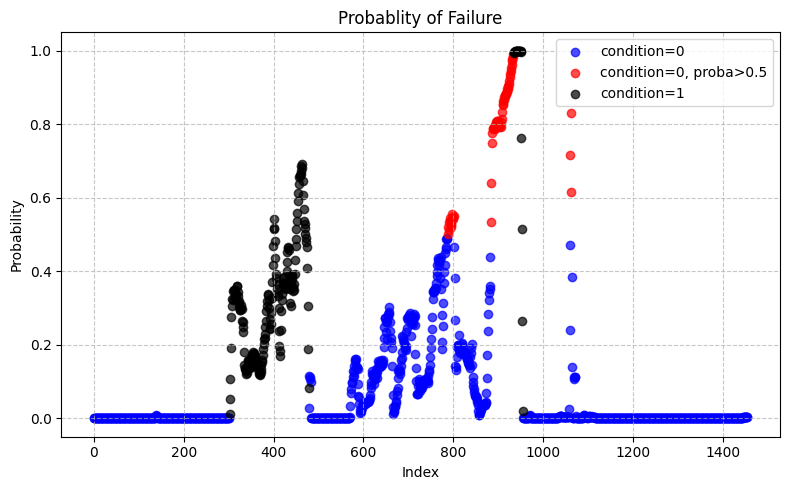

In [51]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df1

aggregated_probabilities = agg_new_deneme(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6, "yes", "yes", "no", "no", 100)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

                 Importance
DV_pressure        0.209297
counter            0.203041
Cluster            0.165738
Oil_temperature    0.149480
Reservoirs         0.089095
Motor_current      0.068008
H1                 0.058707
MPG                0.034811
COMP               0.012753
DV_eletric         0.007943
LPS                0.001098
Pressure_switch    0.000017
Towers             0.000013
R-squareddd: 0.9999843144554111
F-Value Like: 281190308.60560817


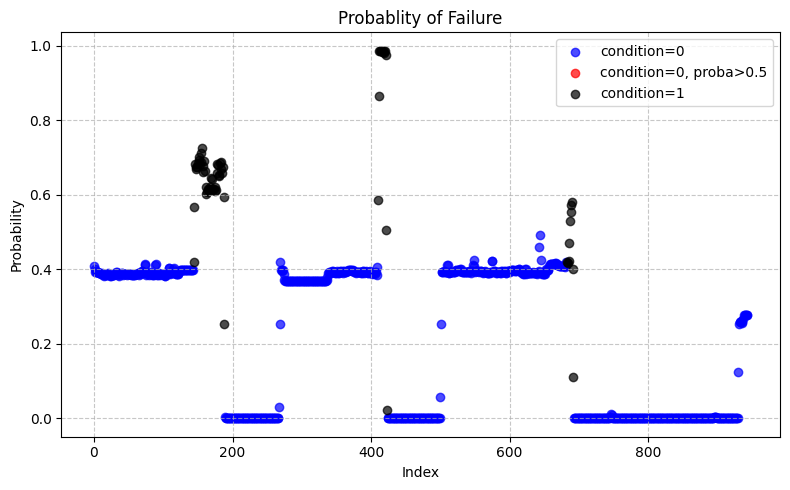

In [53]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df7

aggregated_probabilities = agg_random_forest(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6, "no", "no", "yes", "no", 200)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

/Users/abdullahfurkanarslan/Graduation-Project-2/mpt_functions.py:418: RuntimeWarning: invalid value encountered in sqrt
  se_coef = np.sqrt(var_coef)
/Users/abdullahfurkanarslan/Graduation-Project-2/mpt_functions.py:421: RuntimeWarning: divide by zero encountered in divide
  z_scores = model.coef_[0] / se_coef


                   Coefficient   p_value
data_point_number     9.560774  0.000000
LPS                  -4.467330  0.000000
counter               3.757673  0.000000
Oil_temperature       2.941073       NaN
H1                   -2.688515       NaN
Pressure_switch       1.514443  0.000000
Motor_current        -1.223116       NaN
TP3                  -0.953987  0.366080
TP2                  -0.929603       NaN
DV_pressure           0.927808  0.000000
Reservoirs           -0.694717  0.000233
COMP                 -0.613000       NaN
DV_eletric           -0.494726  0.000000
Oil_level            -0.460892       NaN
Caudal_impulses      -0.460892       NaN
MPG                  -0.289837  0.361429
Towers               -0.012733  0.000000
Intercept: -11.399844332680116
R-squareddd: 0.9651920432826979
F-Value: 257191.9576366486


/Users/abdullahfurkanarslan/Graduation-Project-2/mpt_functions.py:418: RuntimeWarning: invalid value encountered in sqrt
  se_coef = np.sqrt(var_coef)
/Users/abdullahfurkanarslan/Graduation-Project-2/mpt_functions.py:421: RuntimeWarning: divide by zero encountered in divide
  z_scores = model.coef_[0] / se_coef


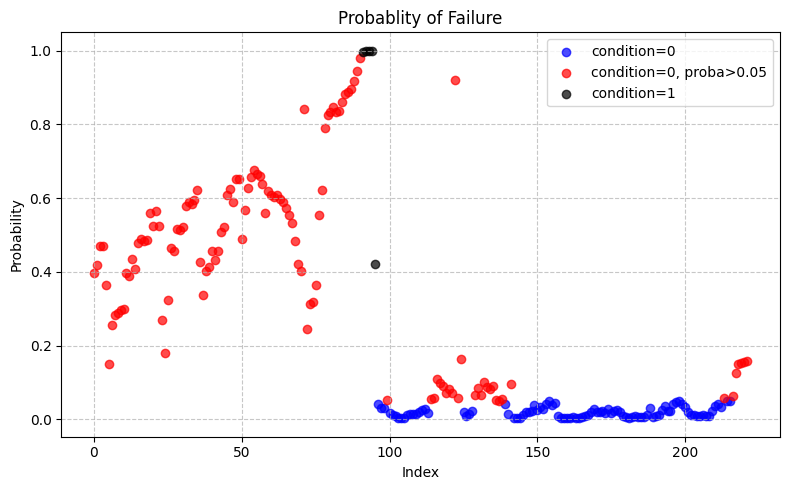

In [9]:
aggregation_size = 400

treshold_probability = 0.05

dataframe = df4

aggregated_probabilities = aggregate(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

/Users/abdullahfurkanarslan/Graduation-Project-2/mpt_functions.py:418: RuntimeWarning: invalid value encountered in sqrt
  se_coef = np.sqrt(var_coef)
/Users/abdullahfurkanarslan/Graduation-Project-2/mpt_functions.py:421: RuntimeWarning: divide by zero encountered in divide
  z_scores = model.coef_[0] / se_coef


                   Coefficient   p_value
data_point_number     9.560774  0.000000
LPS                  -4.467330  0.000000
counter               3.757673  0.000000
Oil_temperature       2.941073       NaN
H1                   -2.688515       NaN
Pressure_switch       1.514443  0.000000
Motor_current        -1.223116       NaN
TP3                  -0.953987  0.366080
TP2                  -0.929603       NaN
DV_pressure           0.927808  0.000000
Reservoirs           -0.694717  0.000233
COMP                 -0.613000       NaN
DV_eletric           -0.494726  0.000000
Oil_level            -0.460892       NaN
Caudal_impulses      -0.460892       NaN
MPG                  -0.289837  0.361429
Towers               -0.012733  0.000000
Intercept: -11.399844332680116
R-squareddd: 0.9651920432826979
F-Value: 257191.9576366486


/Users/abdullahfurkanarslan/Graduation-Project-2/mpt_functions.py:418: RuntimeWarning: invalid value encountered in sqrt
  se_coef = np.sqrt(var_coef)
/Users/abdullahfurkanarslan/Graduation-Project-2/mpt_functions.py:421: RuntimeWarning: divide by zero encountered in divide
  z_scores = model.coef_[0] / se_coef


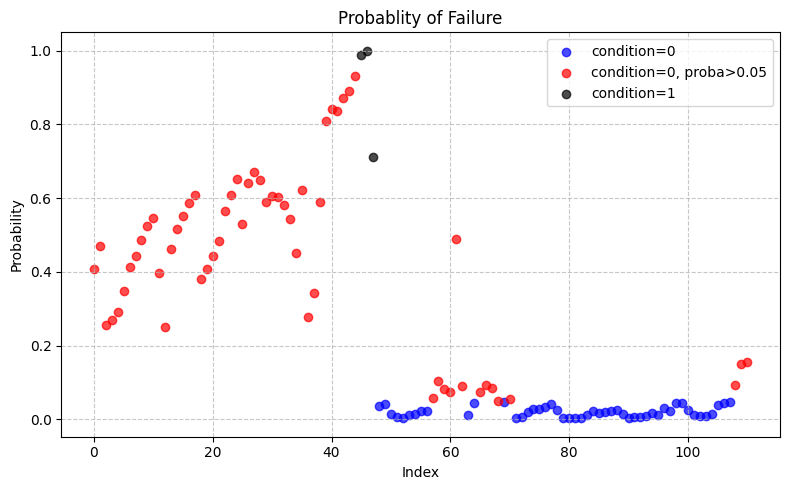

In [10]:
aggregation_size = 800

treshold_probability = 0.05

dataframe = df4

aggregated_probabilities = aggregate(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

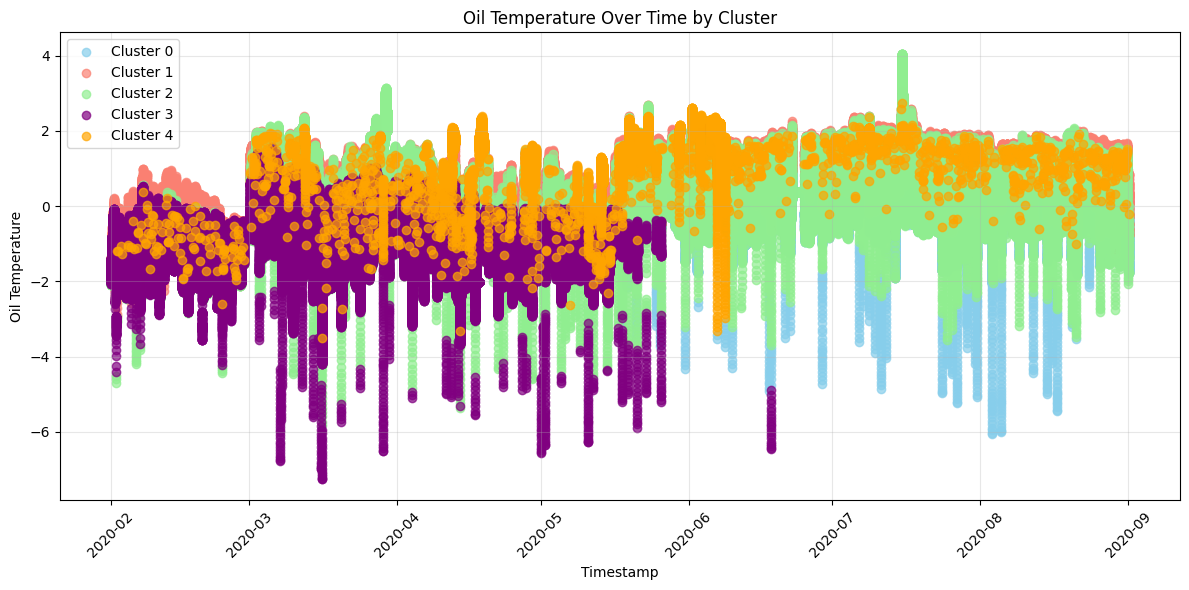

In [11]:
# Reset index if needed
df_plot = df_clustered.reset_index()

# Assuming df_clustered has:
# - A timestamp column (adjust name if different)
# - 'Oil_temperature' column
# - 'Cluster' column with cluster assignments

plt.figure(figsize=(12, 6))

# Define 5 distinct colors for the clusters
cluster_colors = ['skyblue', 'salmon', 'lightgreen', 'purple', 'orange']

# Create scatter plot with timestamps on x-axis, oil temp on y-axis
# and points colored by cluster
for i, cluster_id in enumerate(sorted(df_plot['Cluster'].unique())):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['timestamp'],  # x-axis: timestamps
        cluster_data['Oil_temperature'],  # y-axis: oil temperature
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        # Use the color from our list based on the index
        color=cluster_colors[i % len(cluster_colors)]  # The modulo ensures we don't go out of bounds
    )

plt.xlabel('Timestamp')
plt.ylabel('Oil Temperature')
plt.title('Oil Temperature Over Time by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # Rotate timestamp labels for better readability
plt.tight_layout()
plt.show()